对于整个文本，去扫描看看某个序列出现的概率：

![1](images/1.png)

- 当序列很长时，因为文本量不够大，很可能$ n(x_1, ... , x_T) \le 1 $
- 使用马尔科夫假设可以缓解这个问题：
    - 一元语法表示 $ \tau == 0，即当前元素和前面没有关系 $（一元用得不多，二元、三元用得比较多）
    - 二元语法表示 $ \tau == 1，即当前元素只和前一个元素有关系 $
        注：若采用二元语法，在实际使用过程中由于要考虑到所有的可能性，因此若token字典长度为$n$，那么所有的二元词组的可能有$ n^2 $种
    - 。。。
    


In [1]:
import random
import torch
from d2l import torch as d2l

tokens = d2l.tokenize(d2l.read_time_machine())
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

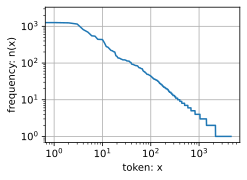

In [2]:
# 词频图，可以发现词频衰减非常快（可能文章中80%的词 都是常用的 20%）
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')


In [3]:
'''
    zip函数：
    >>> a = [1,2,3]
    >>> b = [4,5,6]
    >>> c = [4,5,6,7,8]
    >>> zipped = zip(a,b)     # 打包为元组的列表
    [(1, 4), (2, 5), (3, 6)]
    此处第一个参数把corpus的第一个去掉，第二个参数去掉最后一个
    则得到的就是每个单词和其后一个单词的组合
'''
# 二元
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]


[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [4]:
# 三元（可以做多元，然后对于每种元都只取多的一部分？）
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]


[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

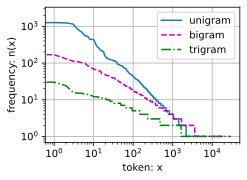

In [5]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot(
    [freqs, bigram_freqs, trigram_freqs], 
    xlabel='token: x',
    ylabel='frequency: n(x)', 
    xscale='log', yscale='log',
    legend=['unigram', 'bigram', 'trigram']
)


In [6]:
def seq_data_iter_random(corpus, batch_size, num_steps):  # @save
    """使用随机抽样生成一个小批量子序列"""
    """算法把数据切成长度为T的序列，设置一个起点随机偏移量k（不然每次切出来的结果都一样）"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引（就是每个子序列开始的位置）
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)


In [7]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)


X:  tensor([[20, 21, 22, 23, 24],
        [15, 16, 17, 18, 19]]) 
Y: tensor([[21, 22, 23, 24, 25],
        [16, 17, 18, 19, 20]])
X:  tensor([[5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [ 1,  2,  3,  4,  5]])
X:  tensor([[25, 26, 27, 28, 29],
        [10, 11, 12, 13, 14]]) 
Y: tensor([[26, 27, 28, 29, 30],
        [11, 12, 13, 14, 15]])


In [8]:
# 按顺序生成
def seq_data_iter_sequential(corpus, batch_size, num_steps):  # @save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y


In [9]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)


X:  tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]])
X:  tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]])


In [10]:
# 将上面的两个采样函数包装到一个类中
class SeqDataLoader:  # @save
    """加载序列数据的迭代器"""

    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)


In [11]:
def load_data_time_machine(batch_size, num_steps,  # @save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab
